# FD002

In [1]:
!wget https://ti.arc.nasa.gov/c/6/ -O data.zip
!unzip data.zip
!pip install lifelines

--2021-04-30 16:47:48--  https://ti.arc.nasa.gov/c/6/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip [following]
--2021-04-30 16:47:49--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  11.85M  4.99MB/s    in 2.4s    

2021-04-30 16:47:51 (4.99 MB/s) - ‘data.zip’ saved [12425978/12425978]

Archive:  data.zip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001.txt           
  inflating: RUL_FD002.txt           
  inflating: RUL_FD003.txt 

In [2]:
# load necessary packages
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter
%matplotlib inline

In [3]:
inputdir = ""

#seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

# Preparing datasets

In [4]:
# the files did not contain headers. Here we create labels based on documentation
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
na_columns = ["NA1", "NA2"]
column_names = index_columns_names + op_settings_columns + sensor_columns + na_columns

# load data
df_train= pd.read_csv(inputdir+'train_FD002.txt', sep=" ", header=None, names = column_names)
df_test = pd.read_csv(inputdir+'test_FD002.txt', sep=" ", header=None, names = column_names)

# drop NULL columns
df_train.drop(df_train.columns[[26, 27]], axis=1, inplace=True)
df_test.drop(df_test.columns[[26, 27]], axis=1, inplace=True)

display(df_train)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,13.66,334.00,2324.92,8852.27,1.07,44.72,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,15.50,392.46,2319.17,8915.86,1.26,46.08,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,9.04,175.11,1917.37,8114.33,0.94,37.14,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,9.04,174.81,1917.36,8112.63,0.94,37.32,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


# Adding Failure indicators and Cycle starts

In [5]:
df_train["IsFailure"] = 0
idx_failure = (np.where(df_train["Cycle"] ==1)[0] - 1)[1:]
df_train["IsFailure"][idx_failure] = 1
df_train["CycleStart"] = df_train["Cycle"]-1
df_train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,0,0
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,0,1
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,0,2
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,0,3
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,13.66,334.00,2324.92,8852.27,1.07,44.72,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,0,311
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,15.50,392.46,2319.17,8915.86,1.26,46.08,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,0,312
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,9.04,175.11,1917.37,8114.33,0.94,37.14,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,0,313
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,9.04,174.81,1917.36,8112.63,0.94,37.32,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,0,314


In [6]:
drop_sensors = op_settings_columns +['Sensor_1','Sensor_5','Sensor_6','Sensor_10','Sensor_16','Sensor_18','Sensor_19']
X = df_train.drop(labels=drop_sensors, axis=1)
X

,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,555.32,1358.61,1137.23,194.64,2222.65,8341.91,42.02,183.06,2387.72,8048.56,9.3461,334,14.73,8.8071,0,0
1,1,2,549.90,1353.22,1125.78,138.51,2211.57,8303.96,42.20,130.42,2387.66,8072.30,9.3774,330,10.41,6.2665,0,1
2,1,3,537.31,1256.76,1047.45,175.71,1915.11,8001.42,36.69,164.22,2028.03,7864.87,10.8941,309,14.08,8.6723,0,2
3,1,4,549.51,1354.03,1126.38,138.46,2211.58,8303.96,41.96,130.72,2387.61,8068.66,9.3528,329,10.59,6.4701,0,3
4,1,5,537.07,1257.71,1047.93,175.05,1915.10,7993.23,36.89,164.31,2028.00,7861.23,10.8963,309,14.13,8.5286,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,608.79,1495.60,1269.51,334.00,2324.92,8852.27,44.72,314.05,2389.02,8169.64,9.3035,369,24.36,14.5189,0,311
53755,260,313,605.81,1514.32,1324.12,392.46,2319.17,8915.86,46.08,371.22,2388.42,8245.36,8.7586,374,28.10,16.9454,0,312
53756,260,314,537.48,1276.24,1057.92,175.11,1917.37,8114.33,37.14,163.74,2030.33,7971.25,11.0657,310,14.19,8.5503,0,313
53757,260,315,537.84,1272.95,1066.30,174.81,1917.36,8112.63,37.32,164.37,2030.35,7972.47,11.0537,311,14.05,8.3729,0,314


In [7]:
df_test["IsFailure"] = 0
idx_failure = (np.where(df_test["Cycle"] ==1)[0] - 1)[1:]
df_test["IsFailure"][idx_failure] = 1
df_test["CycleStart"] = df_test["Cycle"]-1
X_test = df_test[X.columns]
X_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,605.03,1497.17,1304.99,394.54,2318.96,8763.80,45.61,371.69,2388.18,8114.10,8.6476,369,28.42,17.1551,0,0
1,1,2,607.82,1481.20,1246.11,334.36,2323.95,8713.21,44.26,315.32,2388.12,8053.06,9.2405,364,24.29,14.8039,0,1
2,1,3,556.00,1359.08,1128.36,193.55,2222.67,8340.20,41.80,183.04,2387.75,8053.04,9.3472,333,14.98,8.9125,0,2
3,1,4,550.17,1349.69,1127.89,138.74,2211.58,8313.85,42.21,130.40,2387.72,8066.90,9.3961,332,10.35,6.4181,0,3
4,1,5,536.72,1253.18,1050.69,175.75,1915.10,7997.13,36.76,164.56,2028.05,7865.66,10.8682,305,14.31,8.5740,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,555.56,1366.01,1129.47,194.87,2223.24,8367.35,41.96,183.05,2388.39,8088.36,9.3215,334,14.94,8.9065,0,118
33987,259,120,549.42,1351.13,1123.86,138.34,2212.19,8339.94,42.00,130.74,2388.31,8108.48,9.3542,332,10.57,6.4075,0,119
33988,259,121,549.65,1349.14,1118.91,138.27,2212.29,8341.70,42.15,130.96,2388.34,8098.77,9.3836,331,10.57,6.4805,0,120
33989,259,122,642.58,1589.61,1408.16,553.13,2388.05,9077.35,47.47,522.25,2388.00,8161.85,8.4279,393,39.08,23.3589,0,121


In [8]:
from lifelines import CoxPHFitter
cph = CoxTimeVaryingFitter()

cph.fit(X, id_col='UnitNumber', event_col='IsFailure', start_col='CycleStart', stop_col='Cycle')
cph.print_summary() 

<lifelines.CoxTimeVaryingFitter: fitted with 53759 periods, 260 subjects, 259 events>
         event col = 'IsFailure'
number of subjects = 260
 number of periods = 53759
  number of events = 259
partial log-likelihood = -609.09
  time fit was run = 2021-04-30 16:47:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sensor_2    1.10       3.00       0.22             0.67             1.52                 1.96                 4.59
Sensor_3    0.09       1.09       0.02             0.06             0.12                 1.06                 1.13
Sensor_4    0.08       1.09       0.01             0.06             0.11                 1.06                 1.12
Sensor_7   -0.05       0.95       0.13            -0.31             0.21                 0.73                 1.23
Sensor_8   -1.03       0.36       0.12            -1.26            -0.79                 0.28                 0.45
Sensor_9    0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04
Sensor_11   5.45     233.25       0.56             4.35             6.56                77.20               704.76
Sensor_12  -0.29       0.75       0.14            -0.57            -0.01                 0.57                 0.99
Sensor_13   0.76       2.15       0.09             0.59             0.94                 1.81                 2.55
Sensor_14  -0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
Sensor_15  24.51   4.40e+10       2.09            20.42            28.59             7.38e+08             2.62e+12
Sensor_17   0.45       1.57       0.07             0.32             0.58                 1.38                 1.79
Sensor_20   2.22       9.18       0.56             1.11             3.32                 3.04                27.72
Sensor_21   3.61      36.90       0.91             1.82             5.40                 6.16               221.11

              z      p   -log2(p)
covariate                        
Sensor_2   5.07 <0.005      21.25
Sensor_3   5.39 <0.005      23.76
Sensor_4   5.89 <0.005      27.96
Sensor_7  -0.38   0.70       0.51
Sensor_8  -8.67 <0.005      57.63
Sensor_9   0.94   0.35       1.53
Sensor_11  9.66 <0.005      70.98
Sensor_12 -2.05   0.04       4.64
Sensor_13  8.68 <0.005      57.86
Sensor_14 -0.12   0.90       0.15
Sensor_15 11.75 <0.005     103.51
Sensor_17  6.69 <0.005      35.37
Sensor_20  3.93 <0.005      13.54
Sensor_21  3.95 <0.005      13.64
---
Partial AIC = 1246.18
log-likelihood ratio test = 1156.89 on 14 df
-log2(p) of ll-ratio test = 788.94

In [9]:
#prediction
pred_cols = ['Cycle',
 'Sensor_2',
 'Sensor_3',
 'Sensor_4',
 'Sensor_7',
 'Sensor_8',
 'Sensor_9',
 'Sensor_11',
 'Sensor_12',
 'Sensor_13',
 'Sensor_14',
 'Sensor_15',
 'Sensor_17',
 'Sensor_20',
 'Sensor_21',
 'IsFailure',
 'CycleStart']

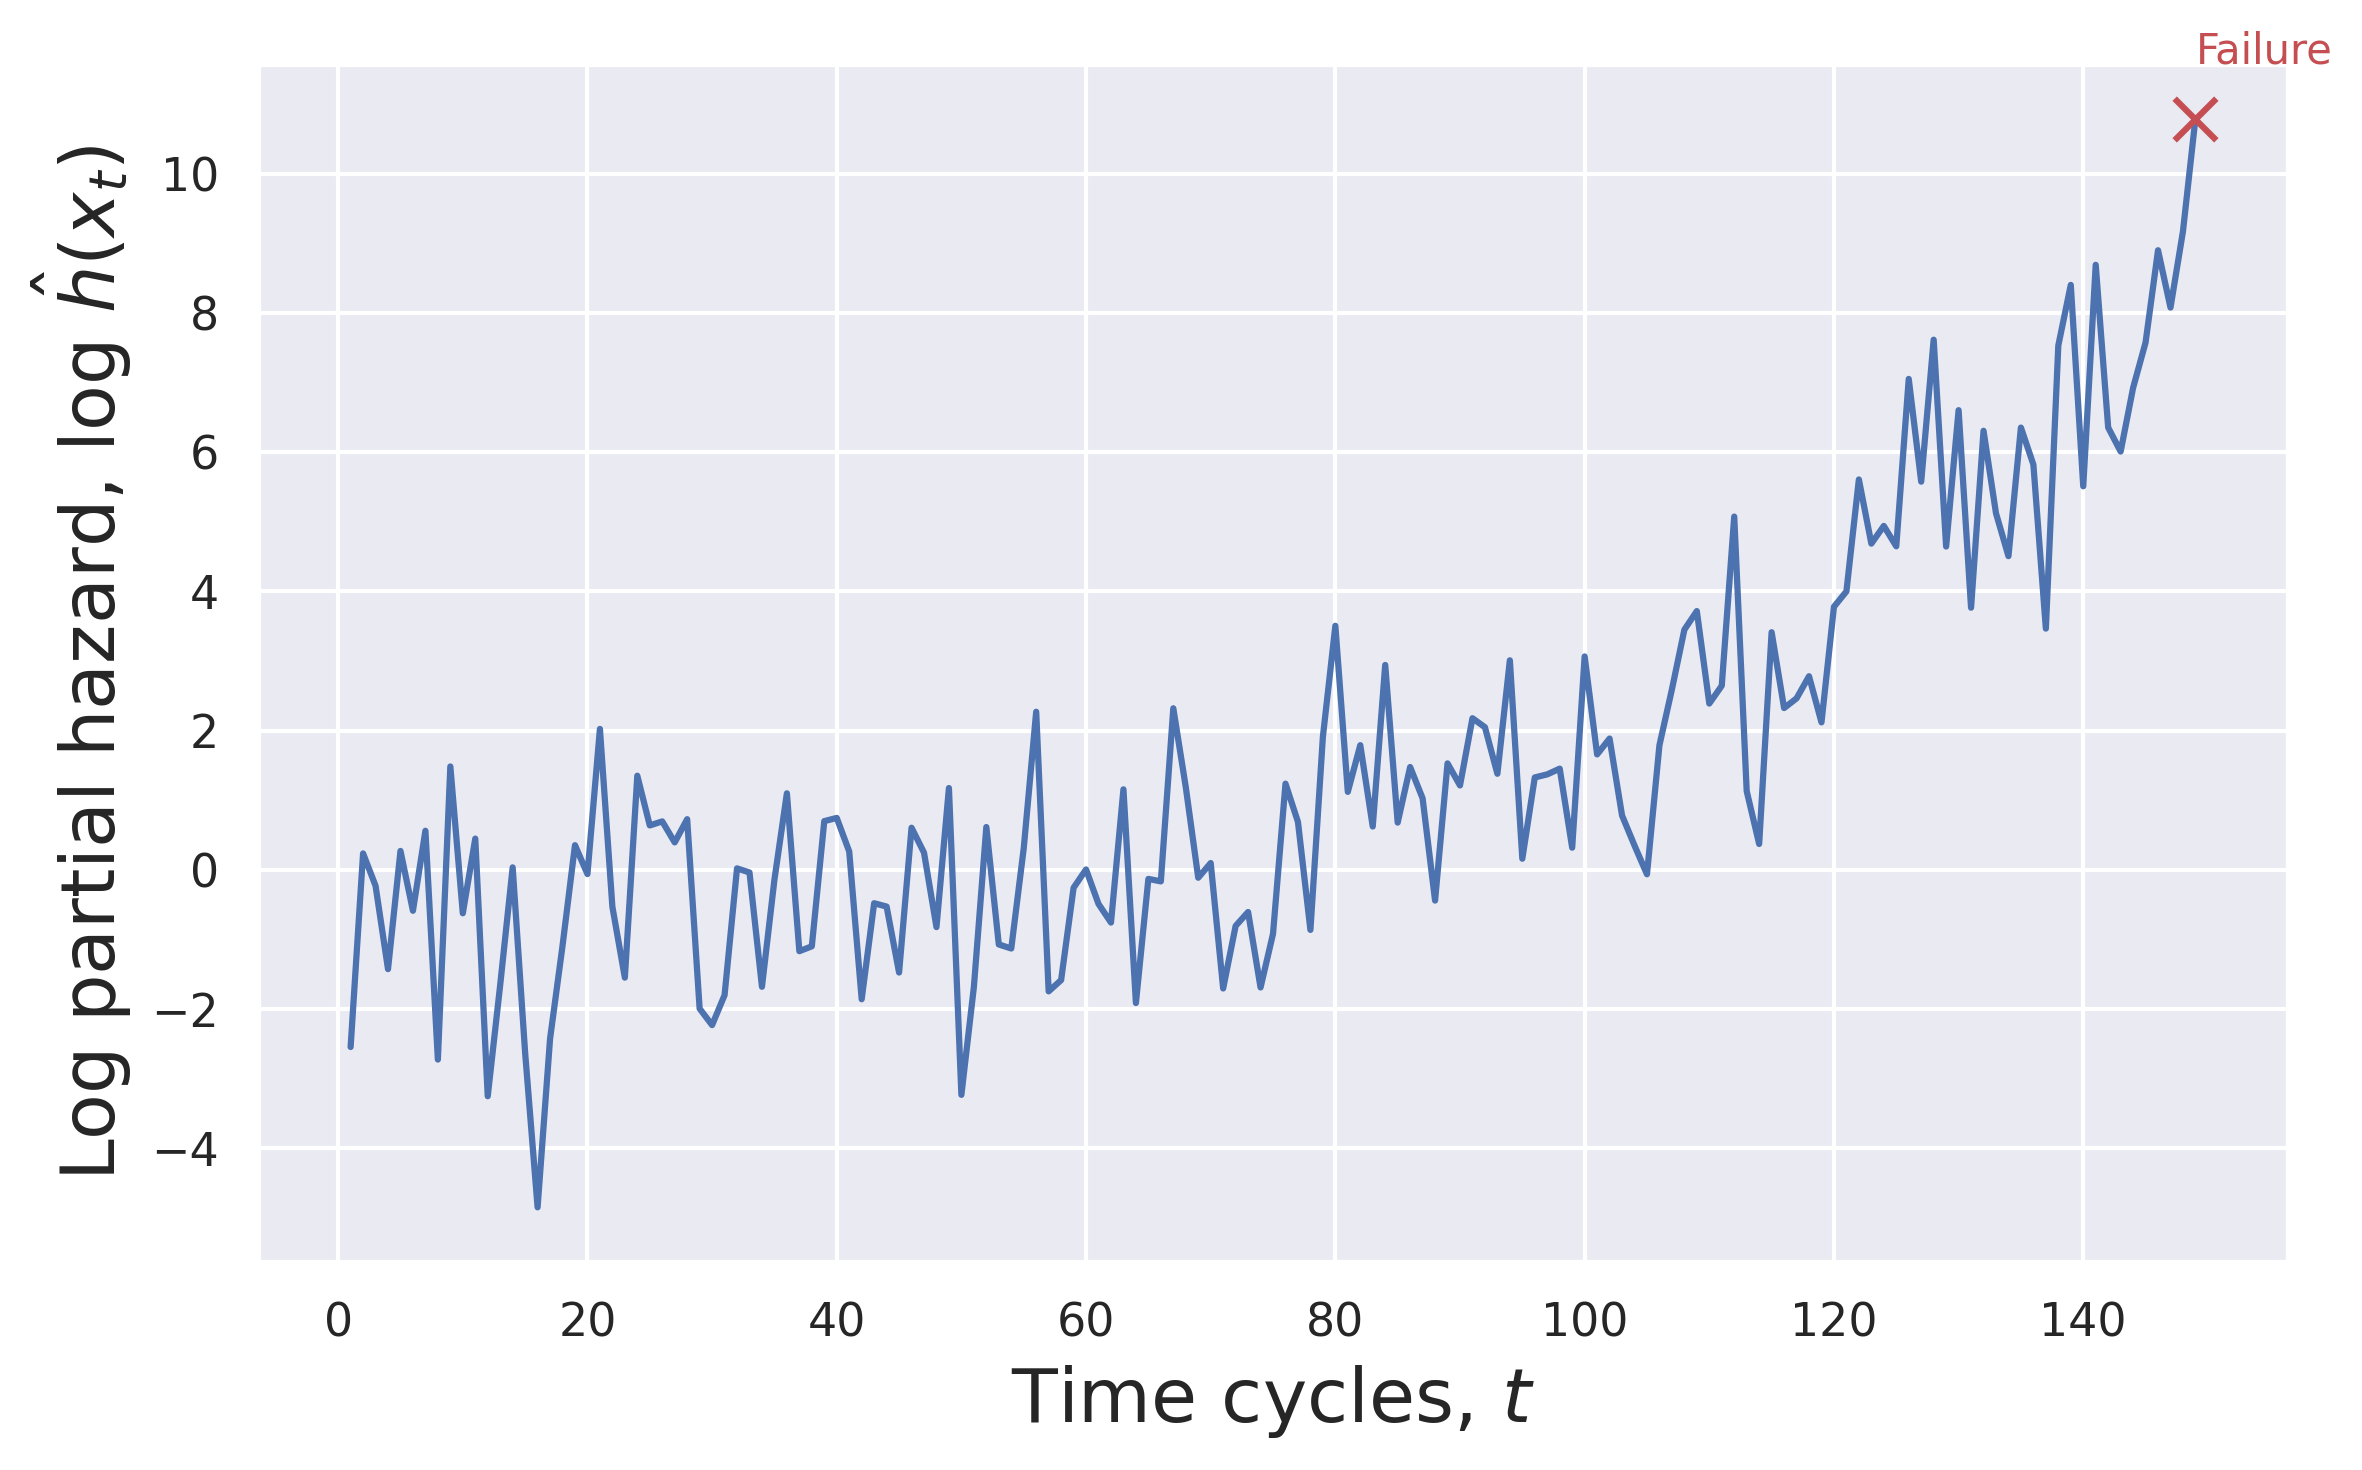

In [10]:
plt.figure(figsize=(8,5), dpi=300)


X_sub = X.loc[X['UnitNumber'] == 1]
predictions = cph.predict_partial_hazard(X_sub[pred_cols])
plt.plot(X_sub['Cycle'].values, np.log(predictions))
plt.scatter(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1], s=100, marker="x", zorder=10, c="C3")
plt.text(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]+0.8, "Failure", c="C3", fontsize=10)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.tight_layout()
plt.savefig('fd002_hazard_traj.pdf', format="pdf")
plt.show()
  

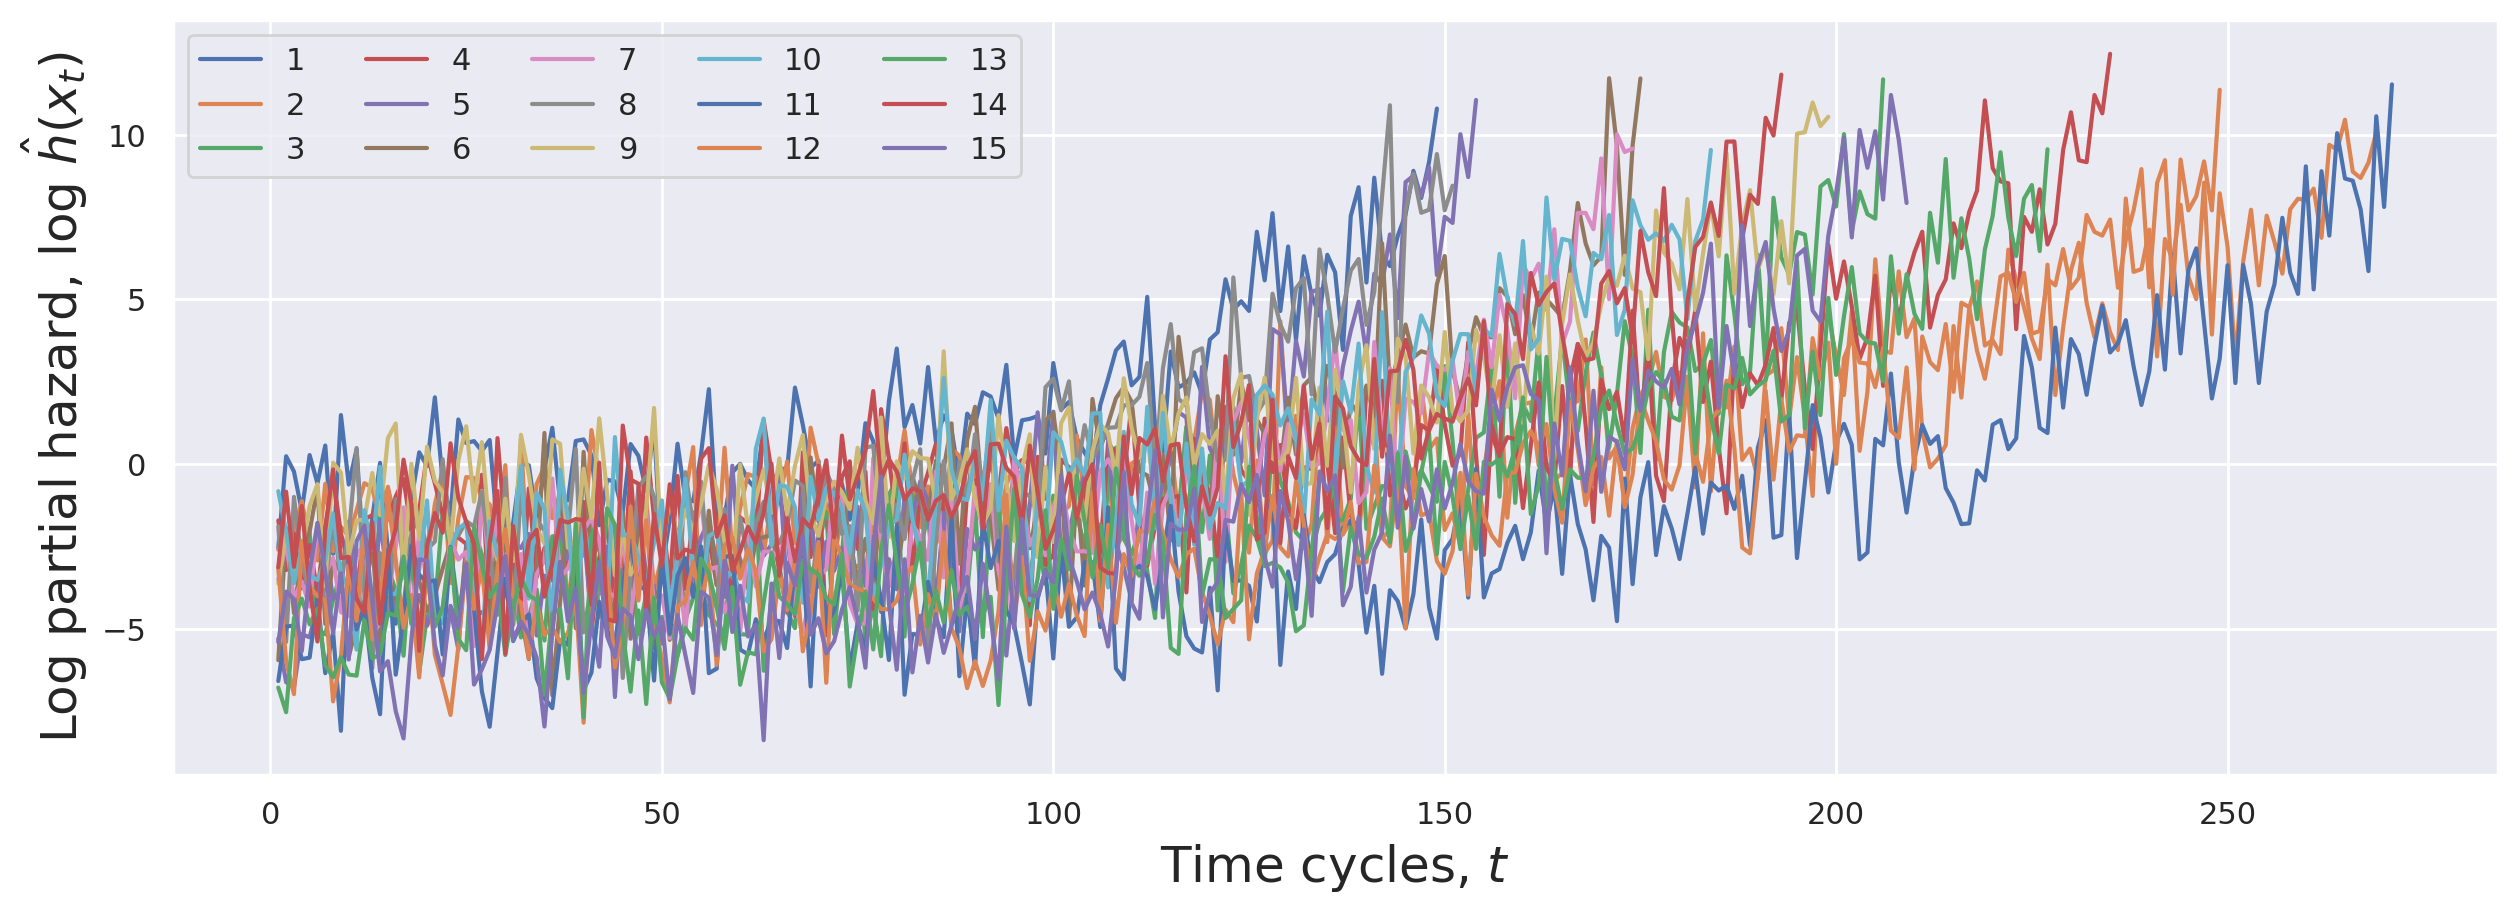

In [11]:
plt.figure(figsize=(15,5), dpi=200)

for i in trange(15):
    X_sub = X.loc[X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    plt.plot(X_sub['Cycle'].values, np.log(predictions), label=i+1)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.legend(ncol=5)
#plt.ylim([10, None])
plt.show()


# Thresholding the hazard score for decision making


In [12]:
#training

llp_replacement=4000000
perf_restoration=3500000

thres_list  = np.arange(7, 14, 1)


rep_num= 10
machine_num = 30

optim_data_mean = []
optim_data_std = []
for thres in thres_list :
  #simulate for rep_num times
  sim_results = []
  for k in trange(rep_num):
    #in each rep select machine_num machines
    machines = np.random.choice(X['UnitNumber'].unique(), size=machine_num)    
    machine_i = []
    for i in range(machine_num):
      X_sub = X.loc[X['UnitNumber'] == machines[i]]
      X_fail = X.loc[X['UnitNumber'] == machines[i]]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep
      
      machine_i.append([is_failed, total_perf_rest, total_llp_rep, total_maintcost])

    machine_i = np.array(machine_i)
    sim_result = [thres, machine_i[:, 0].mean(),  machine_i[:, 1].sum(),  
                  machine_i[:, 2].sum(),  machine_i[:, 3].sum()]
                  

    sim_results.append(sim_result)

  sim_results = np.array(sim_results)
  optim_data_mean.append(sim_results.mean(axis=0))
  optim_data_std.append(sim_results.std(axis=0))

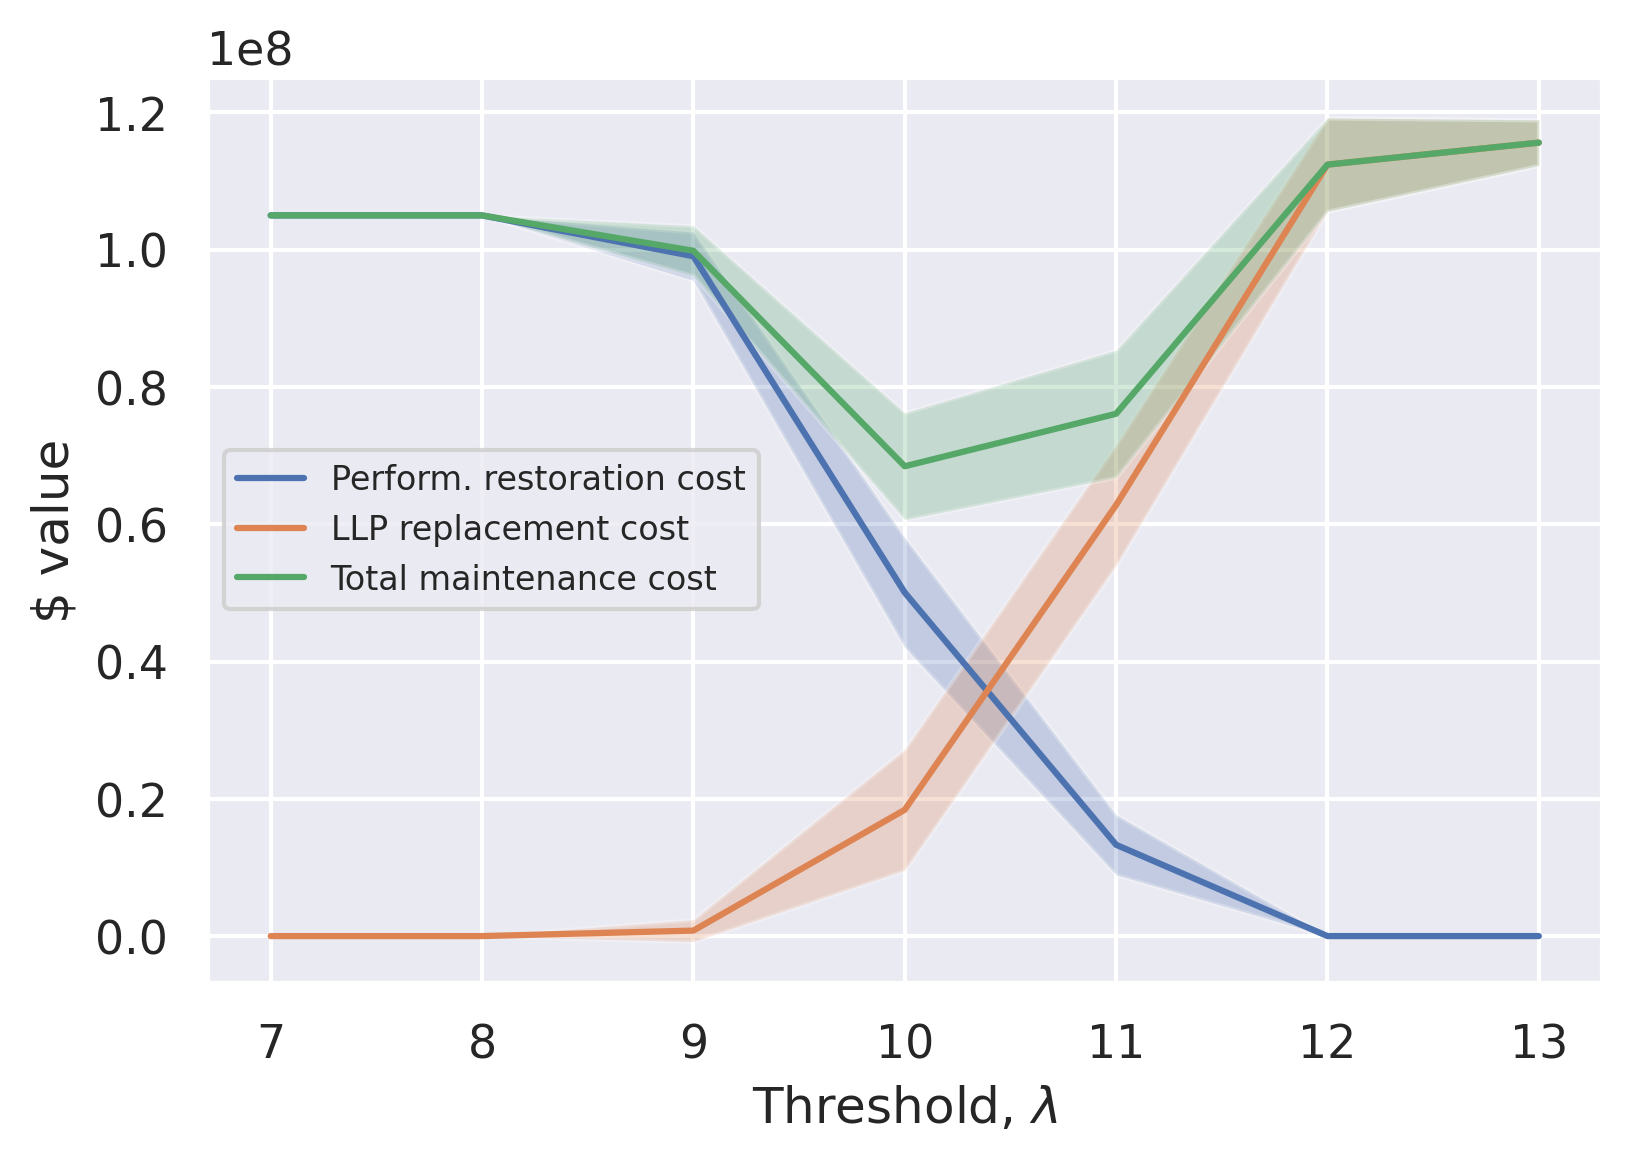

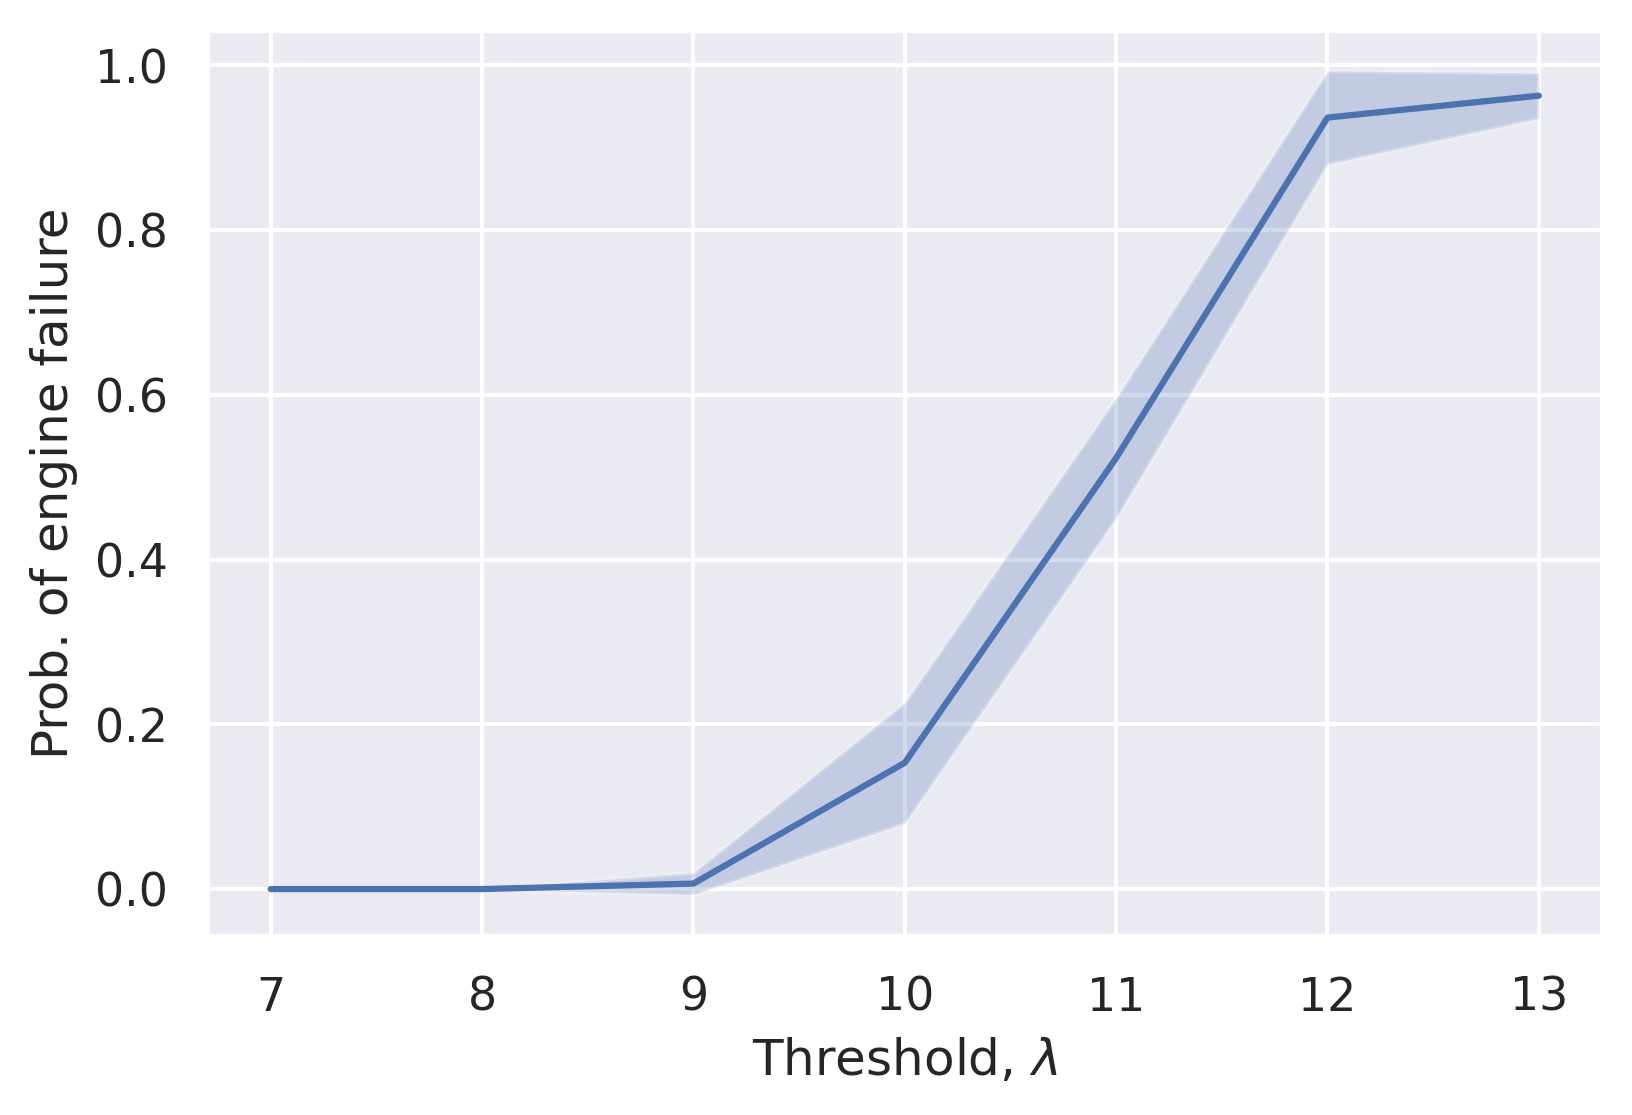

In [13]:
np.save('fd002_mean_', np.array(optim_data_mean))
np.save('fd002_std', np.array(optim_data_std))


mean_ = pd.DataFrame(np.array(optim_data_mean), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])
std_ = pd.DataFrame(np.array(optim_data_std), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])#

opt_thres_idx = mean_['maint_cost'].argmin()
opt_thres = thres_list[opt_thres_idx]

plt.figure(dpi=300)

plt.plot(thres_list, mean_['perf_rest'], label='Perform. restoration cost')
plt.fill_between(thres_list, mean_['perf_rest'] -std_['perf_rest'],  
                 mean_['perf_rest'] +std_['perf_rest'], alpha=0.25)

plt.plot(thres_list, mean_['llp_rep'], label='LLP replacement cost')
plt.fill_between(thres_list, mean_['llp_rep'] -std_['llp_rep'],  
                 mean_['llp_rep'] +std_['llp_rep'], alpha=0.25)

plt.plot(thres_list, mean_['maint_cost'], label='Total maintenance cost')
plt.fill_between(thres_list, mean_['maint_cost'] -std_['maint_cost'],  
                 mean_['maint_cost'] +std_['maint_cost'], alpha=0.25)

plt.xlabel('Threshold, $\lambda$')
plt.ylabel('$ value')
plt.legend( fontsize=8)
plt.savefig('fd002_cost.pdf', format='pdf')
plt.show()

plt.figure(dpi=300)
plt.plot(thres_list, mean_['fail_prob'], label='Engine failure probability')
plt.fill_between(thres_list, mean_['fail_prob'] -std_['fail_prob'],  
                 mean_['fail_prob'] +std_['fail_prob'], alpha=0.25)
plt.xlabel('Threshold, $\lambda$')
plt.ylabel('Prob. of engine failure')
plt.savefig('fd002_prob.pdf', format='pdf')
plt.show()


In [14]:
mean_

,thres,fail_prob,perf_rest,llp_rep,maint_cost
0,7.0,0.000000,105000000.0,0.0,105000000.0
1,8.0,0.000000,105000000.0,0.0,105000000.0
2,9.0,0.006667,99050000.0,800000.0,99850000.0
3,10.0,0.153333,50050000.0,18400000.0,68450000.0
4,11.0,0.523333,13300000.0,62800000.0,76100000.0
5,12.0,0.936667,0.0,112400000.0,112400000.0
6,13.0,0.963333,0.0,115600000.0,115600000.0


### Testing [We'll ignore this for now and focus on using training set]

In [15]:
#testing

machine_test_i = []
thres = opt_thres
for i in trange(X_test['UnitNumber'].max()):
      X_sub = X_test.loc[X_test['UnitNumber'] == i+1]
      X_fail = X_test.loc[X_test['UnitNumber'] == i+1]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep      
      machine_test_i.append([thres, is_failed, total_perf_rest, total_llp_rep, total_maintcost])

In [16]:
opt_thres

10

In [17]:
result_test = pd.DataFrame(np.array(machine_test_i), columns=['thres', 'is_failed', 'perf_rest', 'llp_rep', 'maint_cost'])
result_thres_test = result_test.groupby('thres').sum().reset_index()
result_thres_test['is_failed'] = result_thres_test['is_failed']/X_test['UnitNumber'].max()
result_thres_test


,thres,is_failed,perf_rest,llp_rep,maint_cost
0,10,0.969112,10500000,1004000000,1014500000


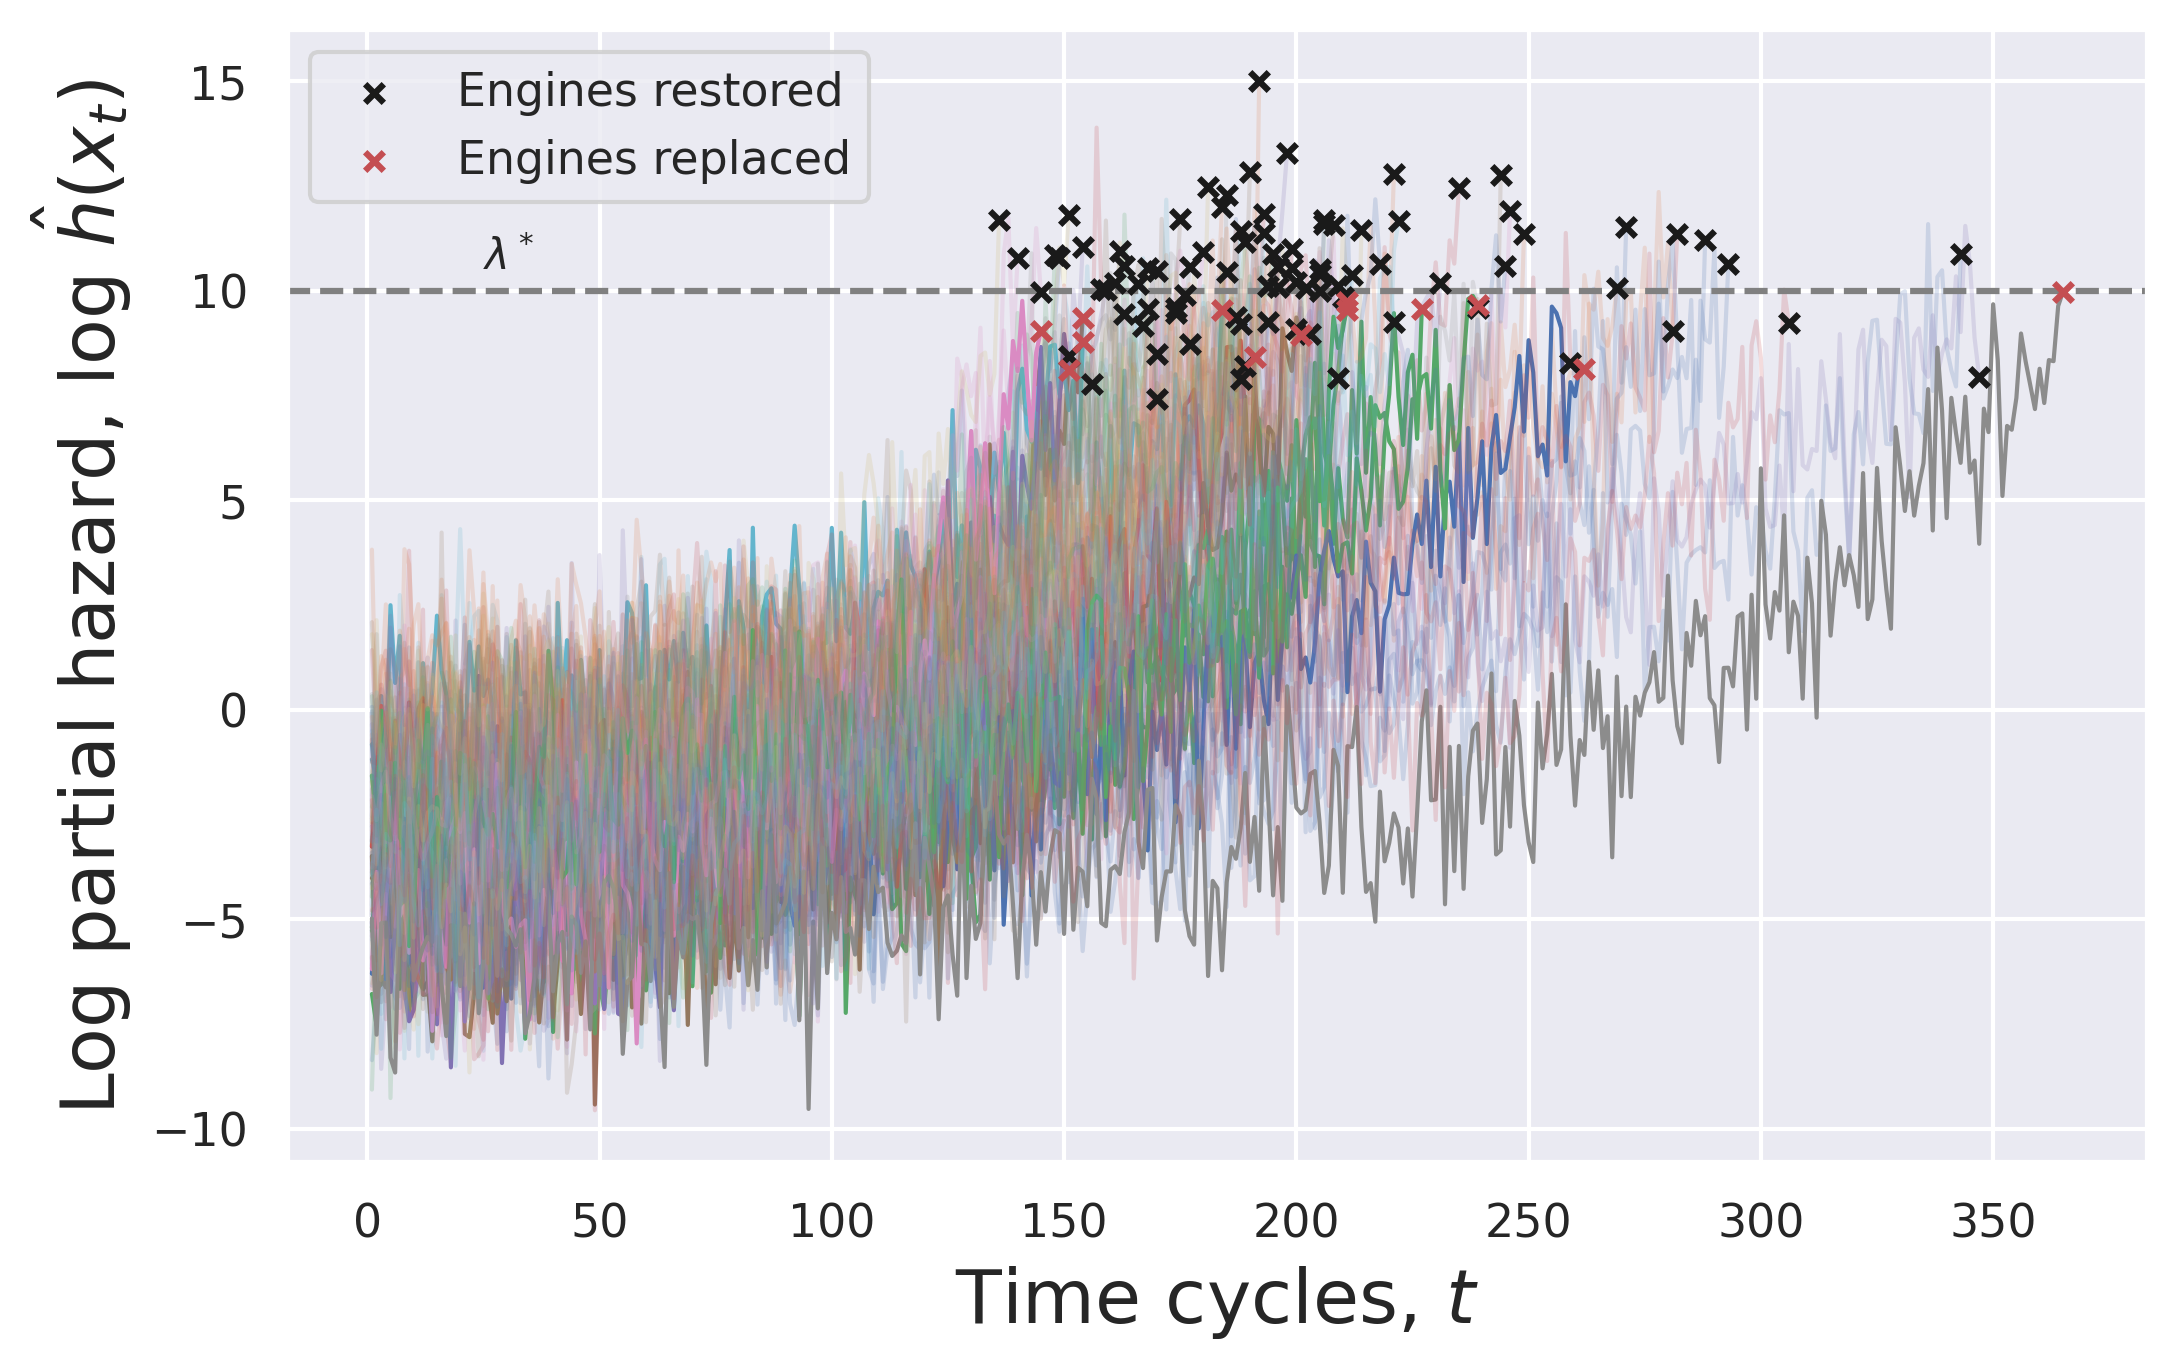

In [18]:
plt.figure(figsize=(8,5), dpi=300)
df_X = X
engines_restored = []
engines_replaced = []
for i in trange(100):
    X_sub = df_X.loc[df_X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    log_partial_hazard = np.log(predictions)
    is_maintained = log_partial_hazard.max() > thres
    plt.plot(X_sub['Cycle'].values, log_partial_hazard, alpha=0.2+0.8*~is_maintained, lw=1)
        
    if is_maintained:
      engines_restored.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])      
    else:
      engines_replaced.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])
engines_restored = np.array(engines_restored)
engines_replaced = np.array(engines_replaced)      

if len(engines_restored) > 0:
  plt.scatter(engines_restored[:, 0], engines_restored[:, 1], s=20, marker="x", zorder=10, c="k", label="Engines restored")  
if len(engines_replaced) > 0:
  plt.scatter(engines_replaced[:, 0], engines_replaced[:, 1], s=20, marker="x", zorder=10, c="r", label="Engines replaced")


plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.text(25, thres+0.5, '$\lambda^*$')
plt.legend()
plt.axhline(thres, c='gray', linestyle="dashed")
plt.savefig('sim_result_fd002.pdf',format="pdf")
plt.show()